# Deep Otello AI

The game reversi is a very good game to apply deep learning methods to.

Othello also known as reversi is a board game first published in 1883 by eiter Lewis Waterman or John W. Mollet in England (each one was denouncing the other as fraud).
It is a strickt turn based zero-sum game with a clear Markov chain and now hidden states like in card games with an unknown distribution of cards or unknown player allegiance.
There is like for the game go only one set of stones with two colors which is much easier to abstract than chess with its 6 unique pieces.
The game has a symmetrical game board wich allows to play with rotating the state around an axis to allow for a breaking of sequences or interesting ANN architectures, quadruple the data generation by simulation or interesting test cases where a symetry in turns should be observable if the AI reaches an "objective" policy.

## The game rules

Othello is played on a board with 8 x 8 fields for two player.
The board geometry is equal to a chess game.
The game is played with game stones that are black on one siede and white on the other.

![Othello game board example](reversi_example.png)

The player take turns.
A player places a stone with his or her color up on the game board.
The player can only place stones when he surrounds a number of stones with the opponents color with the new stone and already placed stones of his color.
Those surrounded stones can either be horizontally, vertically and/or diagonally be placed.
All stones thus surrounded will be flipped to be of the players color.
Turns are only possible if the player is also changing the color of the opponents stones. If a player can't act he is skipped.
The game ends if both players can't act. The player with the most stones wins.
If the score is counted in detail unclaimed fields go to the player with more stones of his or her color on the board.
The game begins with four stones places in the center of the game. Each player gets two. They are placed diagonally to each other.


<img alt="Startaufstellung.png" src="Startaufstellung.png"/>

## Some common Othello strategies

As can be easily understood the placement of stones and on the bord is always a careful balance of attack and defence.
If the player occupies huge homogenous stretches on the board it can be attacked easier.
The boards corners provide safety from wich occupied territory is impossible to loos but since it is only possible to reach the corners if the enemy is forced to allow this or calculates the cost of giving a stable base to the enemy it is difficult to obtain.
There are some text on otello computer strategies which implement greedy algorithms for reversi based on a modified score to each field.
Those different values are score modifiers for a traditional greedy algorithm.
If a players stone has captured such a filed the score reached is multiplied by the modifier.
The total score is the score reached by the player subtracted with the score of the enemy.
The scores change in the course of the game and converges against one. This gives some indications of what to expect from an Othello AI.

<img alt="ComputerPossitionScore" src="computer-score.png"/>


## Initial design decisions

At the beginning of this project I made some design decisions.
The first onw was that I do not want to use a gym library because it limits the data formats accessible.
I choose to implement the hole game as entry in a stack in numpy arrays to be able to accommodate interfacing with a neural network easier and to use scipy pattern recognition tools to implement some game mechanics for a fast simulation cycle.
I chose to ignore player colors as far as I could instead a player perspective was used. Which allowed to change the perspective with a flipping of the sign. (multiplying with -1).
The array format should also allow for data multiplication or the breaking of strikt sequences by flipping the game along one the for axis, (horizontal, vertical, transpose along both diagonals).

I wanted to implement different agents as classes that act on those game stacks.

Since computation time is critical all computational have results are saved.
The analysis of those is then repeated in real time. If a recalculation of such a section is required the save file can be deleted and the code should be executed again.

In [1]:
%load_ext blackcellmagic
%load_ext line_profiler
%load_ext memory_profiler

## Imports and dependencies

The following direct dependencies where used for this project:
```toml
jupyter = "^1.0.0"
matplotlib = "^3.6.3"
numpy = "^1.24.1"
pytest = "^7.2.1"
python = "3.10.*"
scipy = "^1.10.0"
tqdm = "^4.64.1"
jupyterlab = "^3.6.1"
torchvision = "^0.14.1"
torchaudio = "^0.13.1"
```
* `Jupyter` and `jupyterlab` on pycharm was used as an IDE / Ipython was used to implement this code.
* `matplotlib` was used for visualisation and statistics.
* `numpy` was used for array support and mathematical functions
* `tqdm` was used for progress bars
* `scipy` contains fast pattern recognition tools for images. It was used to make an initial estimation about where possible turns should be.
* `torch` supplied the ANN functionalities.

In [2]:
import pickle
import abc
import itertools
import os.path
from abc import ABC
from enum import Enum
from typing import Final
from IPython.display import clear_output, display
from pathlib import Path
import glob
import copy
from functools import lru_cache, wraps

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.nn import functional
from ipywidgets import interact
from scipy.ndimage import binary_dilation
from tqdm.notebook import tqdm

## Constants

Some general constants needed to be defined. Such as board game size and Player and Enemy representations. Also, directional offsets and the initial placement of blocks.

In [3]:
BOARD_SIZE: Final[int] = 8  # defines the board side length as 8
PLAYER: Final[int] = 1  # defines the number symbolising the player as 1
ENEMY: Final[int] = -1  # defines the number symbolising the enemy as -1
EXAMPLE_STACK_SIZE: Final[int] = 1000  # defines the game stack size for examples
IMPOSSIBLE: Final[np.ndarray] = np.array([-1, -1], dtype=int)
IMPOSSIBLE.setflags(write=False)
SIMULATE_TURNS: Final[int] = 70
VERIFY_POLICY: Final[bool] = False
TRAINING_RESULT_PATH: Final[Path] = Path("training_data")
if not os.path.exists(TRAINING_RESULT_PATH):
    os.mkdir(TRAINING_RESULT_PATH)

The directions array contains all the numerical offsets needed to move along one of the 8 directions in a 2 dimensional grid. This will allow an iteration over the game board.

![8-directions.png](8-directions.png "Offset in 8 directions")

In [4]:
DIRECTIONS: Final[np.ndarray] = np.array(
    [[i, j] for i in range(-1, 2) for j in range(-1, 2) if j != 0 or i != 0],
    dtype=int,
)
DIRECTIONS.setflags(write=False)
DIRECTIONS

array([[-1, -1],
       [-1,  0],
       [-1,  1],
       [ 0, -1],
       [ 0,  1],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1]])

Another constant needed is the initial start square at the center of the board.

In [5]:
START_SQUARE: Final[np.ndarray] = np.array(
    [[ENEMY, PLAYER], [PLAYER, ENEMY]], dtype=int
)
START_SQUARE.setflags(write=False)
START_SQUARE

array([[-1,  1],
       [ 1, -1]])

## Creating new boards

The first function implemented and tested is a function to generate the starting environment as a stack of games.
As described above I simply placed a 2 by 2 square in the center of an empty stack of boards.

In [6]:
def get_new_games(number_of_games: int) -> np.ndarray:
    """Generates a stack of initialised game boards.

    Args:
        number_of_games: The size of the board stack.

    Returns: The generates stack of games as a stack n x 8 x 8.

    """
    empty = np.zeros([number_of_games, BOARD_SIZE, BOARD_SIZE], dtype=int)
    empty[:, 3:5, 3:5] = START_SQUARE
    return empty


get_new_games(1)[0]

array([[ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  1,  0,  0,  0],
       [ 0,  0,  0,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [7]:
test_number_of_games = 3
assert get_new_games(test_number_of_games).shape == (
    test_number_of_games,
    BOARD_SIZE,
    BOARD_SIZE,
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=1),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
np.testing.assert_equal(
    get_new_games(test_number_of_games).sum(axis=2),
    np.zeros(
        [
            test_number_of_games,
            8,
        ]
    ),
)
assert np.all(get_new_games(test_number_of_games)[:, 3:4, 3:4] != 0)
del test_number_of_games

## Visualisation tools

In this section a visualisation help was implemented for debugging of the game and a proper display of the results.
For this visualisation ChatGPT was used as a prompted code generator that was later reviewed and refactored by hand to integrate seamlessly into the project as a whole.
White stones represent the player, black stones the enemy. A single plot can be used as a subplot when the `ax` argument is used.

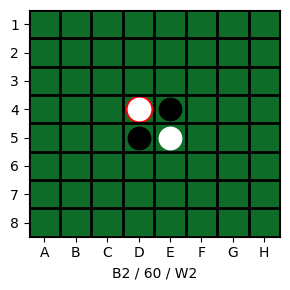

In [8]:
def plot_othello_board(
    board: np.ndarray | torch.Tensor,
    action: np.ndarray | None = None,
    score: float | None = None,
    ax=None,
) -> None:
    """Plots a single otello board.

    If a matplot axis object is given the board will be plotted into that axis. If not an axis object will be generated.
    The image generated will be shown directly.

    Args:
        board: The bord that should be plotted. Only a single games is allowed. A numpy array of the form 8x8 is expected.
        action: The action taken on each board.
        score: The score reached with the turn.
        ax: If needed a matplotlib axis object can be defined that is used to place the board as a sublot into a bigger context.
    """
    # convert a tensor into an array
    if isinstance(board, torch.Tensor):
        board = board.cpu().detach().numpy()

    # ensure the shape of the array fits
    assert board.shape == (8, 8)
    plot_all = False

    # create a figure if no axis is given
    if ax is None:
        fig_size = 3
        plot_all = True
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))

    # set the background color
    ax.set_facecolor("#0f6b28")

    # plot the actions
    if action is not None:
        ax.scatter(action[0], action[1], s=350 if plot_all else 200, c="red")

    # plot black and white stones
    for x_pos, y_pos in itertools.product(range(BOARD_SIZE), range(BOARD_SIZE)):
        if board[x_pos, y_pos] == ENEMY:
            color = "white"
        elif board[x_pos, y_pos] == PLAYER:
            color = "black"
        else:
            continue
        ax.scatter(x_pos, y_pos, s=260 if plot_all else 140, c=color)

    # plot the lines separating the fields
    for x_pos in range(-1, 8):
        ax.axhline(x_pos + 0.5, color="black", lw=2)
        ax.axvline(x_pos + 0.5, color="black", lw=2)

    # define the size of the plot
    ax.set_xlim(-0.5, 7.5)
    ax.set_ylim(7.5, -0.5)

    # set the axis labels
    ax.set_xticks(np.arange(8))
    ax.set_xticklabels(list("ABCDEFGH"))
    ax.set_yticks(np.arange(8))
    ax.set_yticklabels(list("12345678"))

    # overrides the x_label text if a score should be plotted
    if score is None:
        ax.set_xlabel(
            f"B{np.sum(board == PLAYER)} / {np.sum(board == 0)} / W{np.sum(board == ENEMY)}"
        )
    else:
        ax.set_xlabel(f"Score: {score}")
    if plot_all:
        plt.tight_layout()
        plt.show()


plot_othello_board(get_new_games(1)[0], action=np.array([3, 3]))

In [9]:
PLOTS_PER_ROW = 4


def plot_othello_boards(
    boards: np.ndarray,
    actions: np.ndarray | None = None,
    scores: np.ndarray | None = None,
) -> None:
    """Plots multiple boards into subplots.

    The plots are shown directly.

    Args:
        boards: Plots the boards given into subplots. The maximum number of boards accepted is 70.
        actions: A list of actions taken on each of the boards.
        scores: A list of scores reached at each board.
    """
    # checking if the array input shapes do fit
    assert len(boards.shape) == 3
    assert boards.shape[1:] == (BOARD_SIZE, BOARD_SIZE)
    assert boards.shape[0] < 70

    if actions is not None:
        assert len(actions.shape) == 2
        assert actions.shape[1] == 2
        assert boards.shape[0] == actions.shape[0]

    if scores is not None:
        assert len(scores.shape) == 1
        assert boards.shape[0] == scores.shape[0]

    # plots the boards
    rows = int(np.ceil(boards.shape[0] / PLOTS_PER_ROW))
    fig, axs = plt.subplots(rows, PLOTS_PER_ROW, figsize=(12, 3 * rows))
    for game_index, ax in enumerate(axs.flatten()):
        if game_index >= boards.shape[0]:
            fig.delaxes(ax)
        else:
            action = actions[game_index] if actions is not None else None
            score = scores[game_index] if scores is not None else None
            plot_othello_board(boards[game_index], action=action, score=score, ax=ax)
    plt.tight_layout()
    plt.show()

In [10]:
def drop_duplicate_boards(
    boards: np.ndarray,
    actions: np.ndarray | None,
) -> tuple[np.ndarray, np.ndarray | None]:
    """Takes a sequence of boards and drops all boards that are unchanged.

    Args:
        boards: A list of boards to be reduced.
        actions: A list of actions to be reduced alongside the bords.

    Returns:
        A sequence of boards where boards that where equal are dropped.
    """
    non_duplicates = ~np.all(boards == np.roll(boards, axis=0, shift=1), axis=(1, 2))
    return (
        boards[non_duplicates],
        np.roll(actions, axis=0, shift=1)[non_duplicates]
        if actions is not None
        else None,
    )

## Hash Otello Boards

A challenge for training any reinforcement learning algorithm is how to properly calibrate the exploration rate.
To make huge numbers of boards comparable it is easier to work with hashes than with the acutal boards. For that purpose a functionalty to hash a board and a stack of boards was added.

In [11]:
def hash_board(board: np.ndarray) -> int:
    assert board.shape == (8, 8) or board.shape == (64,)
    return hash(tuple(board.reshape(-1)))


def count_unique_boards(boards: np.ndarray) -> int:
    return np.unique(
        np.apply_along_axis(hash_board, axis=1, arr=boards.reshape(-1, 64))
    ).size


a = count_unique_boards(np.random.randint(-1, 2, size=(10_000, 8, 8)))

## Find possible actions to take

The frist step in the implementation of an AI like this is to get an overview over the possible actions that can be taken in a situation.
Here was the design choice taken to first find fields that are empty and have at least one neighbouring enemy stone.
This was implemented with element wise check for a stone and a binary dilation marking all fields neighboring an enemy stone.
For that the `SURROUNDING` mask was used. Both aries are then element wise combined using and.
The resulting array contains all filed where a turn could potentially be made. Those are then check in detail.
The previous element wise operations on the numpy array increase the spead for this operation dramatically.

The check for a possible turn is done in detail by following each direction step by step as long as there are enemy stones in that direction.
If the board end is reached or en empty filed before reaching a field occupied by the player that direction does not surround enemy stones.
If one direction surrounds enemy stone a turn is possible.
This detailed step is implemented as a recursion and need to go at leas one step to return True.

In [12]:
SURROUNDING: Final = np.array(
    [[[1, 1, 1], [1, 0, 1], [1, 1, 1]]]
)  # defines the binary dilation mask to check if a field is next to an enemy stones
SURROUNDING

array([[[1, 1, 1],
        [1, 0, 1],
        [1, 1, 1]]])

To make the computation of this game more feasable the `lru_cache` decorater was used. LRU uses a hash of the arguments to looke up and return a prevusly calculated result of a computationaly heavy operation. For this a code snippet was modified. Numpy arrays are mutable and unhashable. So the decorater was layed into a converion to tuples, use of the caching layer and the back conversion to numpy arrays.
Those then are converted back into numpy arrays. This reduces the calculation time to 30% of what it is without when calculating possible actions to take.

In [13]:
# Source https://gist.github.com/Susensio/61f4fee01150caaac1e10fc5f005eb75
def np_cache(*lru_args, array_argument_elements: tuple[int, ...] = (0,), **lru_kwargs):
    """
    LRU cache implementation for functions whose parameter at ``array_argument_index`` is a numpy array of dimensions <= 2

    Example:
    >>> from sem_env.utils.cache import np_cache
    >>> array = np.array([[1, 2, 3], [4, 5, 6]])
    >>> @np_cache(maxsize=256)
    ... def multiply(array, factor):
    ...     return factor * array
    >>> multiply(array, 2)
    >>> multiply(array, 2)
    >>> multiply.cache_info()
    CacheInfo(hits=1, misses=1, maxsize=256, currsize=1)
    """

    def decorator(function):
        @wraps(function)
        def wrapper(*args, **kwargs):
            args = list(args)
            for array_argument_index in array_argument_elements:
                np_array = args[array_argument_index]
                if len(np_array.shape) > 2:
                    raise RuntimeError(
                        f"np_cache is currently only supported for arrays of dim. less than 3 but got shape: {np_array.shape}"
                    )
                hashable_array = tuple(np_array.reshape(-1))

                args[array_argument_index] = hashable_array
            return cached_wrapper(*args, **kwargs)

        @lru_cache(*lru_args, **lru_kwargs)
        def cached_wrapper(*args, **kwargs):
            args = list(args)
            for array_argument_index in array_argument_elements:
                hashable_array = args[array_argument_index]
                array = np.array(hashable_array).reshape(8, 8)
                args[array_argument_index] = array
            return function(*args, **kwargs)

        # copy lru_cache attributes over too
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear
        return wrapper

    return decorator

In [14]:
def _recursive_steps(
    board: np.ndarray,
    rec_direction: np.ndarray,
    rec_position: np.ndarray,
    step_one: int = 0,
) -> int:
    """Check if a player can place a stone on the board specified in the direction specified and direction specified.

    Args:
        board: The board that should be checked for a playable action.
        rec_direction: The direction that should be checked.
        rec_position: The position that should be checked.
        step_one: Defines if the call of this function is the firs or not. Should be kept to the default value for proper functionality.

    Returns:
        True if a turn is possible for possition and direction on the board defined.
    """
    rec_position = rec_position + rec_direction
    if np.any((rec_position >= BOARD_SIZE) | (rec_position < 0)):
        return 0
    next_field = board[tuple(rec_position.tolist())]
    if next_field == 0:
        return 0
    if next_field == -1:
        return _recursive_steps(
            board, rec_direction, rec_position, step_one=step_one + 1
        )
    if next_field == 1:
        return step_one


@np_cache(maxsize=2000, array_argument_elements=(0, 1))
def _get_possible_turns_for_board(board: np.ndarray, poss_turns: np.ndarray) -> np.ndarray:
    """Calcualtes where turns are possible.
    
    Args:
        board: The board that should be checked for a playable action.
        poss_turns: An array of actions that could be possible. All true fileds are empty and next to an enemy stone.
    """
    for idx, idy in itertools.product(range(BOARD_SIZE), range(BOARD_SIZE)):
        if poss_turns[idx, idy]:
            position = idx, idy
            poss_turns[idx, idy] = any(
                _recursive_steps(board[:, :], direction, position) > 0
                for direction in DIRECTIONS
            )
    return poss_turns


def get_possible_turns(boards: np.ndarray, tqdm_on: bool = False) -> np.ndarray:
    """Analyses a stack of boards.

    Args:
        boards: A stack of boards to check.
        tqdm_on: Uses tqdm to track the progress.

    Returns:
        A stack of game boards containing boolean values showing where turns are possible for the player.
    """
    assert len(boards.shape) == 3, "The number fo input dimensions does not fit."
    assert boards.shape[1:] == (
        BOARD_SIZE,
        BOARD_SIZE,
    ), "The input dimensions do not fit."

    poss_turns = boards == 0  # checks where fields are empty.
    poss_turns &= binary_dilation(
        boards == -1, SURROUNDING
    )  # checks where fields are next to an enemy filed an empty
    iterate_over = range(boards.shape[0])

    if tqdm_on:
        iterate_over = tqdm(iterate_over, total=np.prod(boards.shape))
    for game in iterate_over:
        poss_turns[game] = _get_possible_turns_for_board(boards[game], poss_turns[game])
    return poss_turns


# some simple testing to ensure the function works after simple changes
# this testing is complete, its more of a smoke-test
test_array = get_new_games(3)
expected_result = np.zeros_like(test_array, dtype=bool)
expected_result[:, 4, 5] = expected_result[:, 2, 3] = True
expected_result[:, 5, 4] = expected_result[:, 3, 2] = True
np.testing.assert_equal(get_possible_turns(test_array), expected_result)


%timeit get_possible_turns(get_new_games(10))  # checks turn possibility evaluation time for 10 initial games
# %timeit get_possible_turns(get_new_games(EXAMPLE_STACK_SIZE))  # check turn possibility evaluation time for EXAMPLE_STACK_SIZE initial games

# shows a singe game
get_possible_turns(get_new_games(3))[:1]

175 µs ± 9.12 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


array([[[False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False,  True, False, False, False, False],
        [False, False,  True, False, False, False, False, False],
        [False, False, False, False, False,  True, False, False],
        [False, False, False, False,  True, False, False, False],
        [False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False]]])

Besides the ability to generate an array of possible turns there needs to be a functions that check if a given turn is possible.
On is needed for the action space validation. The other is for validating a players turn.

In [15]:
def move_possible(board: np.ndarray, move: np.ndarray) -> bool:
    """Checks if a turn is possible.

    Checks if a turn is possible. If no turn is possible to input array [-1, -1] is expected.

    Args:
        board: A board where it should be checkt if a turn is possible.
        move: The move that should be taken. Expected is the index of the filed where a stone should be placed [x, y]. If no placement is possible [-1, -1] is expected as an input.

    Returns:
        True if the move is possible
    """
    if np.all(move == -1):
        return not np.any(get_possible_turns(np.reshape(board, (1, 8, 8))))
    return any(
        _recursive_steps(board[:, :], direction, move) > 0 for direction in DIRECTIONS
    )


# Some testing for this function and the underlying recursive functions that are called.
assert move_possible(get_new_games(1)[0], np.array([2, 3])) is True
assert move_possible(get_new_games(1)[0], np.array([3, 2])) is True
assert move_possible(get_new_games(1)[0], np.array([2, 2])) is False
assert move_possible(np.zeros((8, 8)), np.array([3, 2])) is False
assert move_possible(np.ones((8, 8)) * 1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * -1, np.array([-1, -1])) is True
assert move_possible(np.ones((8, 8)) * 0, np.array([-1, -1])) is True

In [16]:
def moves_possible(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    """Checks if a stack of moves can be executed on a stack of boards.

    Args:
        boards: A board where the next stone should be placed.
        moves: A stack stones to be placed. Each move is formatted as an array in the form of [x, y] if no turn is possible the value [-1, -1] is expected.

    Returns:
        An array marking for each and every game and move in the stack if the move can be executed.
    """
    arr_moves_possible = np.zeros(boards.shape[0], dtype=bool)
    for game in range(boards.shape[0]):
        if np.all(
            moves[game] == -1
        ):  # can be all or any. All should be faster since most times neither value will be -1.
            arr_moves_possible[game] = not np.any(
                get_possible_turns(np.reshape(boards[game], (1, 8, 8)))
            )
        else:
            arr_moves_possible[game] = any(
                _recursive_steps(boards[game, :, :], direction, moves[game]) > 0
                for direction in DIRECTIONS
            )
    return arr_moves_possible


np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * 1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 3], [3, 2], [3, 2]])),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(get_new_games(3), np.array([[2, 2], [1, 1], [0, 0]])),
    np.array([False] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.ones((3, 8, 8)) * -1, np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)
np.testing.assert_array_equal(
    moves_possible(np.zeros((3, 8, 8)), np.array([[-1, -1]] * 3)),
    np.array([True] * 3),
)

## Execute a chosen action

After an evaluation what turns are possible there needs to be a function that executes a turn.
This next sections does that.

In [17]:
class InvalidTurn(ValueError):
    """
    This error is thrown if a given turn is not valid.
    """

104 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


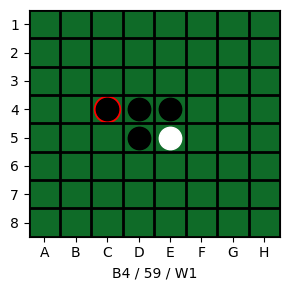

In [18]:
def do_moves(boards: np.ndarray, moves: np.ndarray) -> np.ndarray:
    """Executes a single move on a stack o Othello boards.

    Args:
        boards: A stack of Othello boards where the next stone should be placed.
        moves: A stack of stone placement orders for the game. Formatted as coordinates in an array [x, y] of the place where the stone should be placed. Should contain [-1,-1] if no new placement is possible.

    Returns:
        The new state of the board.
    """

    def _do_directional_move(
        board: np.ndarray, rec_move: np.ndarray, rev_direction, step_one=True
    ) -> bool:
        """Changes the color of enemy stones in one direction.

        This function works recursive. The argument step_one should always be used in its default value.

        Args:
            board: A bord on which a stone was placed.
            rec_move: The position on the board in x and y where this function is called from. Will be moved by recursive called.
            rev_direction: The position where the stone was placed. Inside this recursion it will also be the last step that was checked.
            step_one: Set to true if this is the first step in the recursion. False later on.

        Returns:
            True if a stone could be flipped.
            All changes are made on the view of the numpy array and therefore not included in the return value.
        """
        rec_position = rec_move + rev_direction
        if np.any((rec_position >= 8) | (rec_position < 0)):
            return False
        next_field = board[tuple(rec_position.tolist())]
        if next_field == 0:
            return False
        if next_field == 1:
            return not step_one
        if next_field == -1:
            if _do_directional_move(board, rec_position, rev_direction, step_one=False):
                board[tuple(rec_position.tolist())] = 1
                return True
            return False

    def _do_move(_board: np.ndarray, move: np.ndarray) -> None:
        """Executes a turn on a board.

        Args:
            _board: The game board on wich to place a stone.
            move: The coordinates of a stone that should be placed. Should be formatted as an array of the form [x, y]. The value [-1, -1] is expected if no turn is possible.

        Returns:
            All changes are made on the view of the numpy array.
        """
        if np.all(move == -1):
            if not move_possible(_board, move):
                raise InvalidTurn("An action should be taken. A turn is possible.")
            return

        # noinspection PyTypeChecker
        if _board[tuple(move.tolist())] != 0:
            raise InvalidTurn("This turn is not possible.")

        action = False
        for direction in DIRECTIONS:
            if _do_directional_move(_board, move, direction):
                action = True
        if not action:
            raise InvalidTurn("This turn is not possible.")

        # noinspection PyTypeChecker
        _board[tuple(move.tolist())] = 1

    boards = boards.copy()
    for game in range(boards.shape[0]):
        _do_move(boards[game], moves[game])
    return boards


%timeit do_moves(get_new_games(EXAMPLE_STACK_SIZE), np.array([[2, 3]] * EXAMPLE_STACK_SIZE))[0]

plot_othello_board(
    do_moves(
        get_new_games(EXAMPLE_STACK_SIZE), np.array([[2, 3]] * EXAMPLE_STACK_SIZE)
    )[0],
    action=np.array([2, 3]),
)

## An abstract reversi game policy

For an easy use of policies an abstract class containing the policy generation / requests an action in an inherited instance of this class.
This class filters the policy to only propose valid actions. Inherited instance do not need to care about this. This super class also manges exploration and exploitation with the epsilon value.

In [19]:
class GamePolicy(ABC):
    """
    A game policy. Proposes where to place a stone next.
    """

    def __init__(self, epsilon: float):
        """

        Args:
            epsilon: the epsilon / greedy value. Should be between zero and one. Set the mixture of policy and exploration. One means only the policy is used. Zero means only random policies are used. All mixtures inbetween between are possible.
        """
        if 0 > epsilon > 1:
            raise ValueError("Epsilon should be between zero and one.")
        self._epsilon: float = epsilon

    @property
    def epsilon(self):
        return self._epsilon

    @property
    @abc.abstractmethod
    def policy_name(self) -> str:
        """The name of this policy"""
        raise NotImplementedError()

    @abc.abstractmethod
    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        """The internal policy is an unfiltered policy. It should only be called from inside this function

        Args:
            boards: A board where a policy should be calculated for.

        Returns:
            The policy for this board. Should have the same size as the boards array.
        """
        raise NotImplementedError()

    def get_policy(self, boards: np.ndarray) -> np.ndarray:
        """Calculates the policy that should be followed.

        Calculates the policy that should be followed.
        This function does include the usage of epsilon to configure greediness and exploration.

        Args:
            boards: A set of boards that show the environment where the policy should be calculated for.

        Returns:
            A vector of indices. Should be formatted as an array of the form [x, y]. The value [-1, -1] is expected if no turn is possible.
        """
        assert len(boards.shape) == 3
        assert boards.shape[1:] == (BOARD_SIZE, BOARD_SIZE)

        if self.epsilon <= 0:
            policies = np.random.rand(*boards.shape)
        else:
            policies = self._internal_policy(boards)
            if self.epsilon < 1:
                random_choices = self.epsilon <= np.random.rand((boards.shape[0]))
                policies[random_choices] = np.random.rand(np.sum(random_choices), 8, 8)

        # todo possibly change this function to only validate the purpose turn and not all turns
        possible_turns = get_possible_turns(boards)
        policies[possible_turns == False] = -1.0
        max_indices = [
            np.unravel_index(policy.argmax(), policy.shape) for policy in policies
        ]
        policy_vector = np.array(max_indices, dtype=int)
        no_turn_possible = np.all(policy_vector == 0, 1) & (policies[:, 0, 0] == -1.0)

        policy_vector[no_turn_possible, :] = IMPOSSIBLE
        return policy_vector

## Some first policies

To quantify the quality of a game AI there needs to be some benchmarks.
The easiest benchmark is to play against a random player.
The easiest player to use as a benchmark is the random player.
For this and testing purpose the random policy was implemented.

In [20]:
class RandomPolicy(GamePolicy):
    """
    A policy playing a random turn by setting epsilon to 0.
    """

    def __init__(self, epsilon: float = 0):
        _ = epsilon
        super().__init__(epsilon=0)

    @property
    def policy_name(self) -> str:
        return "random"

    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        pass


rnd_policy = RandomPolicy(1)
assert rnd_policy.policy_name == "random"
assert rnd_policy.epsilon == 0

rnd_policy_result = rnd_policy.get_policy(get_new_games(10))
assert np.any((5 >= rnd_policy_result) & (rnd_policy_result >= 3))

An alternative benchmark policy is a greedy policy that takes always the maximum number of stones possible.

In [21]:
class GreedyPolicy(GamePolicy):
    """
    A policy playing always one of the strongest turns.
    """

    def __init__(self, epsilon: float = 1):
        _ = epsilon
        super().__init__(1)

    @property
    def policy_name(self) -> str:
        return "greedy_policy"

    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        policies = np.random.rand(*boards.shape)
        poss_turns = boards == 0  # checks where fields are empty.
        poss_turns &= binary_dilation(boards == -1, SURROUNDING)
        for game, idx, idy in itertools.product(
            range(boards.shape[0]), range(BOARD_SIZE), range(BOARD_SIZE)
        ):

            if poss_turns[game, idx, idy]:
                position = idx, idy
                policies[game, idx, idy] += np.sum(
                    np.array(
                        list(
                            _recursive_steps(boards[game, :, :], direction, position)
                            for direction in DIRECTIONS
                        )
                    )
                )
        return policies

## Putting the game simulation together
Now it's time to bring all together for a proper simulation.

### Playing a single turn

The next function needed is used to request a policy, verify that the turn is legit and place a stone and turn enemy stones if possible.

In [22]:
def single_turn(
    current_boards: np, policy: GamePolicy
) -> tuple[np.ndarray, np.ndarray]:
    """Execute a single turn on a board.

    Places a new stone on the board. Turns captured enemy stones.

    Args:
        current_boards: The current board before the game.
        policy: The game policy to be used.

    Returns:
        The new game board and the policy vector containing the index of the action used.
    """
    policy_results = policy.get_policy(current_boards)

    # if the constant VERIFY_POLICY is set to true the policy is verified. Should be good though.
    # todo deactivate the policy verification after some testing.
    if VERIFY_POLICY:
        assert np.all(moves_possible(current_boards, policy_results)), (
            current_boards[(moves_possible(current_boards, policy_results) == False)],
            policy_results[(moves_possible(current_boards, policy_results) == False)],
            np.where(moves_possible(current_boards, policy_results) == False),
        )
    return do_moves(current_boards, policy_results), policy_results

### Simulate a stack of games
This function will simulate a stack of games and return an array of policies and histories.

This will return an arrays with the size of (70 x n x 8 x 8) and (70 x n x 2).
The first will contain the boards. The second will contain the actions. If no action is taken the action will be noted as played in (-1, -1).

In [23]:
def simulate_game(
    nr_of_games: int,
    policies: tuple[GamePolicy, GamePolicy],
    tqdm_on: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """Simulates a stack of games.

    Args:
        nr_of_games: The number of games that should be simulated.
        policies: The policies that should be used to simulate the game.
        tqdm_on: Switches tqdm on.

    Returns:
        A stack of board histories and actions.
    """
    board_history_stack = np.zeros((SIMULATE_TURNS, nr_of_games, 8, 8), dtype=np.int8)
    action_history_stack = np.zeros((SIMULATE_TURNS, nr_of_games, 2), dtype=np.int8)
    current_boards = get_new_games(nr_of_games)
    for turn_index in tqdm(range(SIMULATE_TURNS)) if tqdm_on else range(SIMULATE_TURNS):
        policy_index = turn_index % 2
        policy = policies[policy_index]
        board_history_stack[turn_index, :, :, :] = current_boards
        if policy_index == 1:
            current_boards *= -1
        current_boards, action_taken = single_turn(current_boards, policy)
        action_history_stack[turn_index, :] = action_taken

        if policy_index == 1:
            current_boards *= -1

    return board_history_stack, action_history_stack

The first thing to do now is try out how the player act.

## Simulating games

Since now a simulator, a tool for visualisation and two policies exist a few games need to be simulated to verify proper function off all three elements.

### Random vs. random policy
First there is a simulation of a game between two random polices.

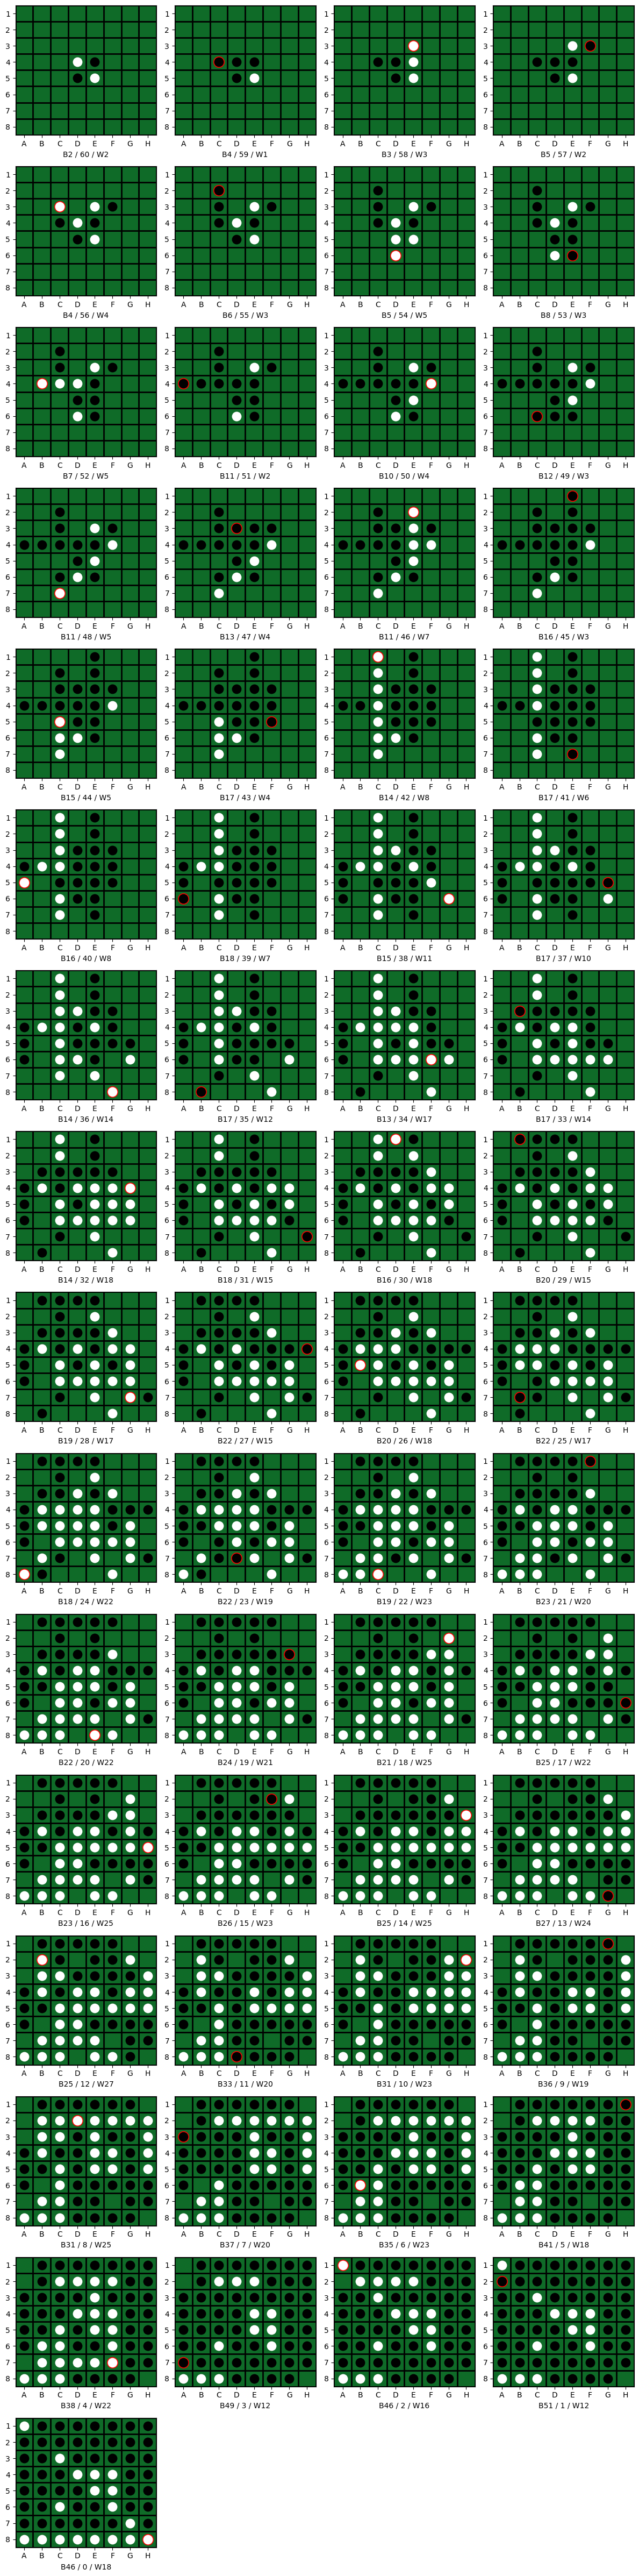

In [24]:
np.random.seed(0)
simulation_results = simulate_game(1, (RandomPolicy(1), RandomPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

In [25]:
%memit simulate_game(100, (RandomPolicy(1), RandomPolicy(1)))
%timeit simulate_game(100, (RandomPolicy(1), RandomPolicy(1)))

peak memory: 341.71 MiB, increment: 1.33 MiB
10.3 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Greedy vs. greedy policy
Then there is a simulation of a game between two greedy policies.

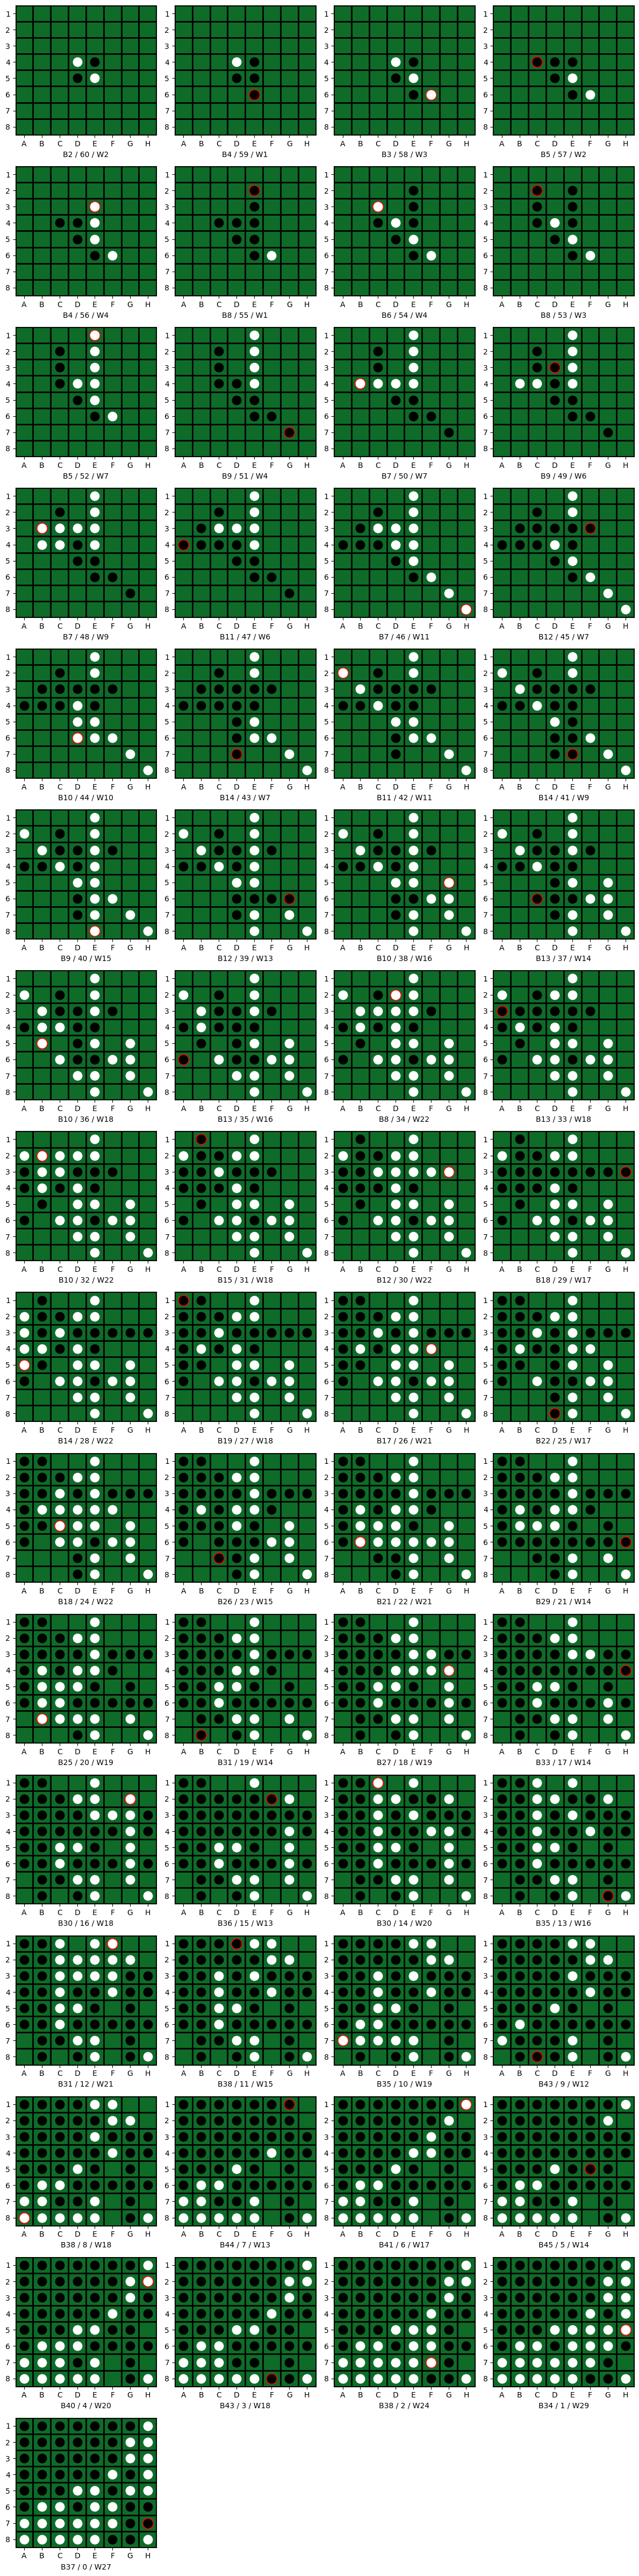

In [26]:
np.random.seed(1)
simulation_results = simulate_game(1, (GreedyPolicy(1), GreedyPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

In [27]:
%memit simulate_game(100, (GreedyPolicy(1), GreedyPolicy(1)))
%timeit simulate_game(100, (GreedyPolicy(1), GreedyPolicy(1)))

peak memory: 347.95 MiB, increment: 0.46 MiB
23.6 s ± 392 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Random vs. greedy policy

Last there was a simulation between random and greedy policy. Random playing as black and the greedy as white.

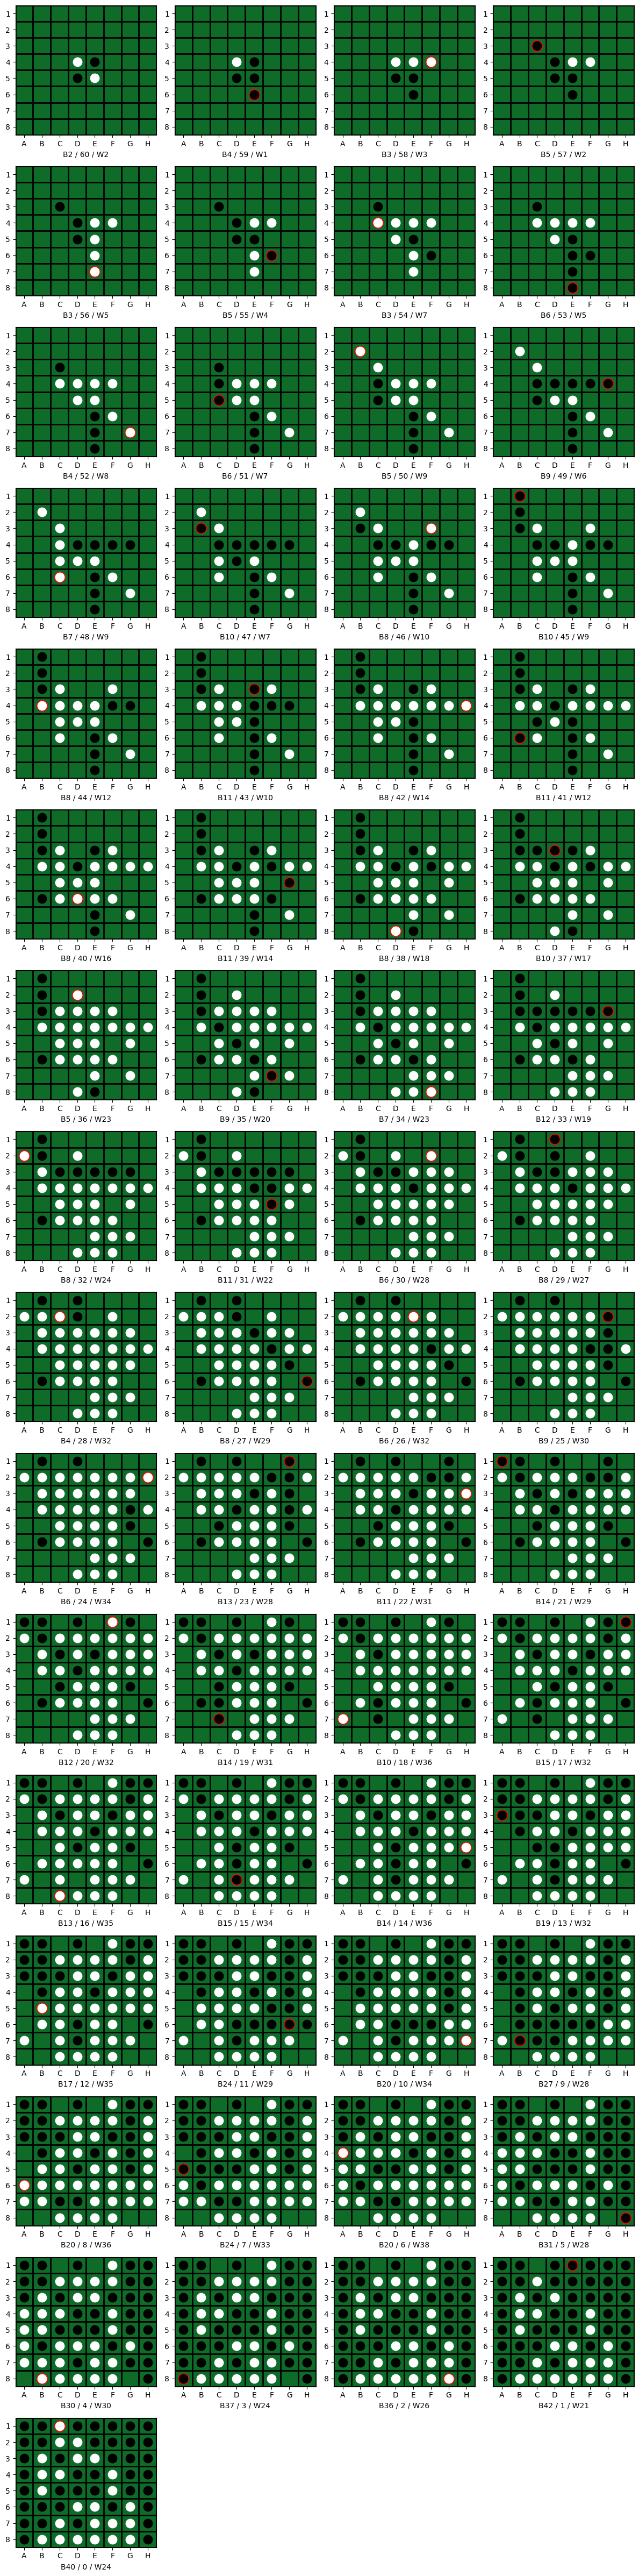

In [28]:
np.random.seed(2)
simulation_results = simulate_game(1, (RandomPolicy(1), GreedyPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

### Greedy vs. random policy

Last there was a simulation between the greedy policy as black and the random policy as white.

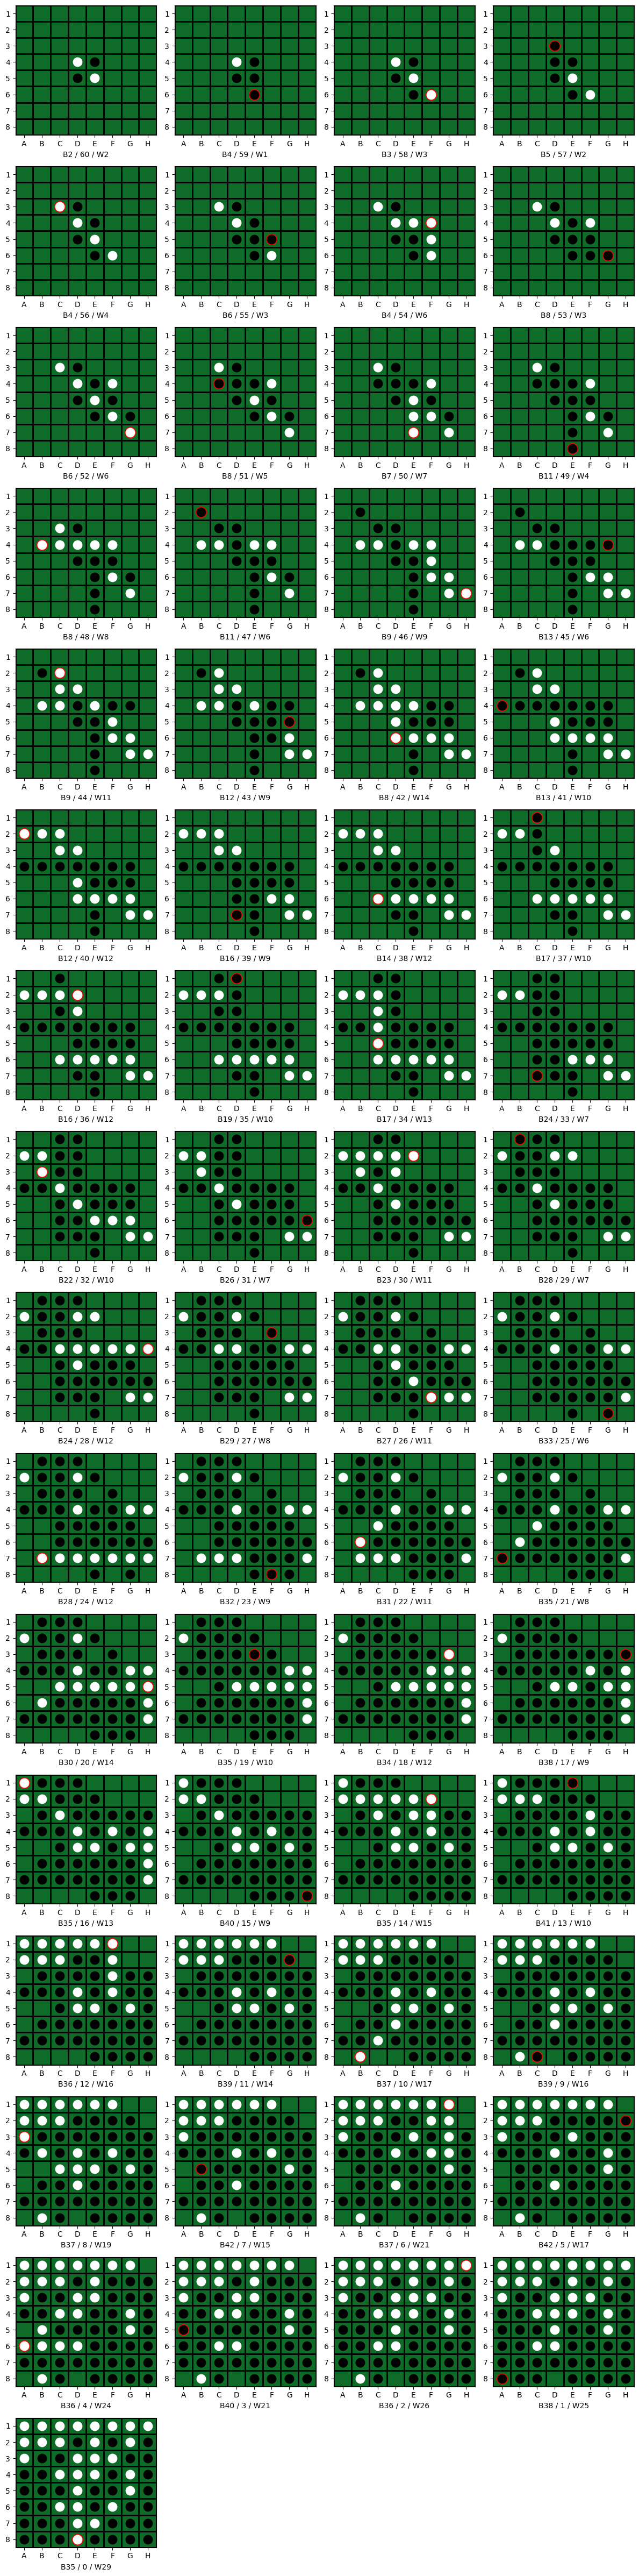

In [29]:
np.random.seed(3)
simulation_results = simulate_game(1, (GreedyPolicy(1), RandomPolicy(1)))
_unique_bords, _unique_actions = drop_duplicate_boards(
    simulation_results[0].reshape(-1, 8, 8), simulation_results[1].reshape(-1, 2)
)
plot_othello_boards(_unique_bords, actions=_unique_actions)

## Statistical examination of the natural action space and game result
As for many project some evaluation of the project is in order.

1. What is the expected distribution of scores
2. What is the expected distribution of possible actions

    a. over time
    
    b. ober space

The easiest and robustest way to analyse this is when analyzing randomly played games.

For this purpose we played a sample of 10,000 games and saved them for later analysis.

In [30]:
if not os.path.exists("rnd_history.npy") and not os.path.exists("rnd_action.npy"):
    simulation_results = simulate_game(
        10_000, (RandomPolicy(1), RandomPolicy(1)), tqdm_on=True
    )
    _board_history, _action_history = simulation_results
    np.save("rnd_history.npy", _board_history.astype(np.int8))
    np.save("rnd_action.npy", _action_history.astype(np.int8))
else:
    _board_history = np.load("rnd_history.npy")
    _action_history = np.load("rnd_action.npy")
_board_history.shape, _action_history.shape

((70, 10000, 8, 8), (70, 10000, 2))

For those 10k games the possible actions where evaluated and saved for each and every turn in the game.

In [31]:
if not os.path.exists("turn_possible.npy"):
    __board_history = _board_history.copy()
    __board_history[1::2] = __board_history[1::2] * -1

    _poss_turns = get_possible_turns(
        __board_history.reshape((-1, 8, 8)), tqdm_on=True
    ).reshape((SIMULATE_TURNS, -1, 8, 8))
    np.save("turn_possible.npy", _poss_turns)
    del __board_history
_poss_turns = np.load("turn_possible.npy")
_poss_turns.shape, _action_history.shape

((70, 10000, 8, 8), (70, 10000, 2))

Those possible turms then where counted for all games in the history stack.

### Action space over time / tree search size estimation
The action space size can be drawn into a histogram by turn and a curve over the mean action space size.
This can be used to analyse in which area of the game that cant be solved absolutely.

In [32]:
count_poss_turns = np.sum(_poss_turns, axis=(2, 3))
mean_possibility_count = np.mean(count_poss_turns, axis=1)
std_possibility_count = np.std(count_poss_turns, axis=1)
cum_prod = count_poss_turns


@interact(turn=(0, 69))
def poss_turn_count(turn):
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    ax1, ax2, ax3, ax4 = axes.flatten()
    _mean_possibility_count = mean_possibility_count.copy()
    _std_possibility_count = std_possibility_count.copy()
    _mean_possibility_count[_mean_possibility_count <= 1] = 1
    _std_possibility_count[_std_possibility_count <= 1] = 1
    # np.cumprod(_mean_possibility_count[::-1], axis=0)[::-1]
    # todo what happens here=
    fig.suptitle(
        f"Action space size analysis\nThe total size is estimated to be around {np.prod(_mean_possibility_count):.2E}"
    )
    ax1.hist(count_poss_turns[turn], density=True)
    ax1.set_title(f"Histogram of the action space size for turn {turn}")
    ax1.set_xlabel("Action space size")
    ax1.set_ylabel("Action space size probability")
    ax2.set_title(f"Mean size of the action space per turn")
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Average possible moves")

    ax2.errorbar(
        range(70),
        mean_possibility_count,
        yerr=std_possibility_count,
        label="Mean action space size with error bars",
    )
    ax2.scatter(turn, mean_possibility_count[turn], marker="x")
    ax2.legend()
    
    action_space_cumprod = np.cumprod(_mean_possibility_count[::-1], axis=0)[::-1]
    ax4.plot(range(70), action_space_cumprod)
    
    ax4.scatter(turn, action_space_cumprod[turn], marker="x")
    ax4.set_yscale("log", base=10)
    ax4.set_xlabel("Turn")
    ax4.set_ylabel("Mean remaining total action space size")
    ax4.set_title(f"Remaining action space at {turn} = {action_space_cumprod[turn].round():.2E}")
    fig.delaxes(ax3)
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=34, description='turn', max=69), Output()), _dom_classes=('widget-intera…

The action space analysis can be used to siwtch betwen a "normal" algorithm and a ANN powered alogrithm. If the average remaining decision tree is small enough.
Depending on the performence of the network and the speed requirements.
After step 52 it should be easely possible. But if wanted to this could start at step 50 or even 48.

It is interesting to see that the action space for the first player (black) is much smaller than for the second player. 

In [33]:
black = mean_possibility_count[0::2]
white = mean_possibility_count[1::2]
df = pd.DataFrame(
    [
        {
            "white": np.prod(np.extract(white, white)),
            "black": np.prod(np.extract(black, black)),
        }
    ],
    index=["Total mean action-space"],
).T
del white, black
df

Total mean action-space
white             3.753117e+20
black             5.687159e+18

### Posiblilty that an action is possible at a specifc turn

The diagramm below shows where and wann a stone can be placed at each of the turns.
This can be used to compare learning behavior for different Policies and show for example the behavior around the corners.
A very low possiblity for a corner would mean that the AI tires not to give the corners to the enemy an tries to capture them themselve if possible.

In [34]:
mean_poss_turn = np.mean(_poss_turns, axis=1)


@interact(turn=(0, 69))
def turn_distribution_heatmap(turn):
    turn_possibility_on_field = mean_poss_turn[turn]

    sns.heatmap(
        turn_possibility_on_field,
        linewidth=0.5,
        square=True,
        annot=True,
        xticklabels="ABCDEFGH",
        yticklabels=list(range(1, 9)),
    )
    plt.title(f"Headmap of where stones can be placed on turn {turn}")

interactive(children=(IntSlider(value=34, description='turn', max=69), Output()), _dom_classes=('widget-intera…

### Statistic of skipped actions

Not all turns can be played. Ploted as a mean over the curse of the game it can be clearly seen that the first time a turn can be skipped is is turn 9 and increases over time.

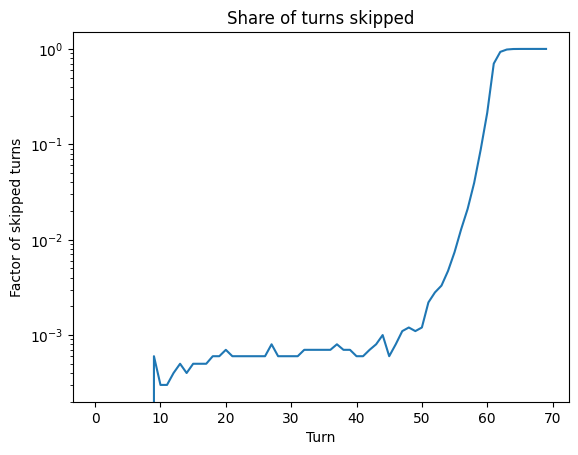

In [111]:
def history_changed(board_history: np.ndarray) -> np.ndarray:
    """Calculates if the board changed between actions.
    
    Args:
        board_history: A history of game baords. Shaped (70 * n * 8 * 8)
    """
    return ~np.all(
        np.roll(board_history, shift=1, axis=0) == board_history, axis=(2, 3)
    )


plt.title("Share of turns skipped")
plt.plot(1 - np.mean(history_changed(_board_history), axis=1))
plt.xlabel("Turn")
plt.ylabel("Factor of skipped turns")
plt.yscale("log", base=10)
plt.show()

## Hash branching
To calibrate the explration rate properly we compared all the games in a stack of games. The graph shows the number of unique game boards at each of the game turns.
As can be seen below for random games the games start to be unique very fast.
For a proper directed exploration I assume the rate needs to be calbrated that the game still have some duplications of the best knwon game at the end of an game simulatin left.

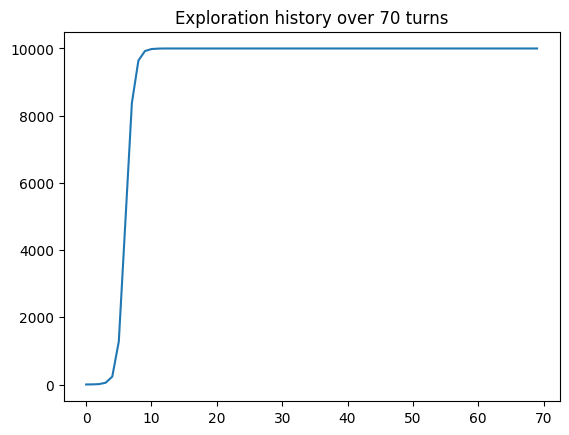

In [35]:
def calculate_board_branching(board_history) -> pd.Series:
    assert len(board_history.shape) == 4
    assert board_history.shape[-2:] == (8, 8)
    assert board_history.shape[0] == SIMULATE_TURNS
    return (
        pd.Series(
            [count_unique_boards(board_history[turn]) for turn in range(SIMULATE_TURNS)]
        )
    )


_ = calculate_board_branching(_board_history).plot(
    title=f"Exploration history over {_board_history.shape[0]} turns"
)

In [36]:
_direct_score = np.sum(_board_history, axis=(-2, -1))
_score = np.zeros_like(_direct_score)
_score[:-1] = _direct_score[1:] - _direct_score[:-1]
print(np.mean(_score, axis=1))

[ 3.0000e+00 -3.0000e+00  3.2566e+00 -3.4776e+00  3.4422e+00 -3.8032e+00
  3.7130e+00 -3.9864e+00  3.9188e+00 -4.1371e+00  4.0475e+00 -4.2540e+00
  4.1889e+00 -4.4112e+00  4.3339e+00 -4.4949e+00  4.5001e+00 -4.5824e+00
  4.5818e+00 -4.7497e+00  4.7366e+00 -4.8246e+00  4.8160e+00 -4.9348e+00
  4.9494e+00 -5.0466e+00  5.1068e+00 -5.1586e+00  5.2366e+00 -5.2766e+00
  5.3122e+00 -5.4081e+00  5.4527e+00 -5.5603e+00  5.5967e+00 -5.6423e+00
  5.7014e+00 -5.8357e+00  5.8643e+00 -5.9012e+00  5.9900e+00 -6.1215e+00
  6.1590e+00 -6.2150e+00  6.3472e+00 -6.4288e+00  6.5409e+00 -6.6730e+00
  6.7297e+00 -6.9038e+00  6.9386e+00 -7.0992e+00  7.2869e+00 -7.4165e+00
  7.5312e+00 -7.7480e+00  7.9052e+00 -7.9656e+00  7.8611e+00 -7.3040e+00
  3.0707e+00 -7.1540e-01  1.4300e-01 -1.9100e-02  3.4000e-03 -3.0000e-04
  5.0000e-04  0.0000e+00  0.0000e+00  0.0000e+00]


## Reword functions

For any kind of reinforcement learning is a reword function needed.
For otello this would be the final score, the information who won, changes to the score and the sum of the board.
A combination of those three also be possible.
It is probably not be possible to weight the current score to high in a reword function since that would be to close to a classic greedy algorithm.
But some direct influence would increase the learning speed.
In the next section are all three reword functions implemented to be combined and weight later on as needed.

### Evaluate the final game score

When playing Otello the empty fileds at the end of the game are conted for the player with more stones.
The folowing function calucates that. The result result will be the delta between the score for player 1 (black).

In [74]:
def final_boards_evaluation(boards: np.ndarray) -> np.ndarray:
    """Evaluates the board at the end of the game.

    All unused fields are added to the score of the player that has more stones with his color up.
    This score only applies to the end of the game.
    Normally the score is represented by the number of stones each player has.
    In this case the score was combined by building the difference.

    Args:
        boards: A stack of game bords ot the end of the game. Shaped (n * 8 * 8)

    Returns:
        the combined score for both player.
    """
    score1, score2 = np.sum(boards == 1, axis=(1, 2)), np.sum(boards == -1, axis=(1, 2))
    player_1_won = score1 > score2
    player_2_won = score1 < score2
    score1_final = 64 - score2[player_1_won] * 2
    score2_final = 64 - score1[player_2_won] * 2
    score = np.zeros(boards.shape[0])
    score[player_1_won] = score1_final
    score[player_2_won] = -score2_final
    return score

np.random.seed(2)
_baords = simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]
np.testing.assert_array_equal(np.sum(_baords[-1], axis=(1,2)), final_boards_evaluation(_baords[-1]))
np.random.seed(2)
np.testing.assert_array_equal(np.array([ -6., -36., -12., -16.,  38., -12.,  2., -22.,   2.,  10.]), final_boards_evaluation(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]))

np.random.seed(2)
boards = simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]
boards[:, 4, :] = 0
np.testing.assert_array_equal(np.array([-14., -38., -14., -22.,  40., -16., -14., -28.,   0.,  20.]),  final_boards_evaluation(boards))

_boards = get_new_games(EXAMPLE_STACK_SIZE)
%timeit final_boards_evaluation(_boards)

219 µs ± 8.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [90]:
def calculate_final_evaluation_for_history(board_history: np.ndarray) -> np.ndarray:
    """Calculates the final scores for a stack of game histories.
    
    Args:
        board_history: A stack of game histories.
    """
    final_evaluation = final_boards_evaluation(board_history[-1])
    return final_evaluation / 64

np.random.seed(2)
_boards = simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]
np.testing.assert_array_equal(np.array([ -6., -36., -12., -16.,  38., -12.,  2., -22.,   2.,  10.]) / 64, calculate_final_evaluation_for_history(_boards))

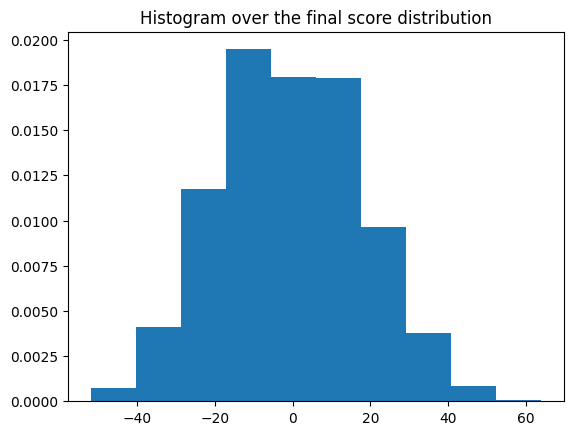

In [96]:
assert len(calculate_final_evaluation_for_history(_board_history).shape) == 1
_final_eval = calculate_final_evaluation_for_history(_board_history)
plt.title("Histogram over the final score distribution")
plt.hist((_final_eval * 64), density=True)
plt.show()

### Evaluation game by stones only

The next evaluation is just by counting stones by color and building the difference between both. In this implementation it can also be called the sum of a board.

In [91]:
def evaluate_boards(boards: np.ndarray) -> np.ndarray:
    """Counts the stones each player has on the board.

    Args:
        boards: A stack of boards for evaluation. Shaped (n * 8 * 8)

    Returns:
        the combined score for both players.
    """
    assert boards.shape[-2:] == (8,8)
    return np.sum(boards, axis=(-1, -2))


np.random.seed(1)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]),
    np.array([-30, -14, -8, 4, -4, -8, -36, 14, -16, -4]),
)
np.random.seed(2)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][-1]),
    np.array([-6, -36, -12, -16, 38, -12, 2, -22, 2, 10]),
)
np.testing.assert_array_equal(
    evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]).shape,
    (70, 10),
)
np.random.seed(3)
np.testing.assert_array_equal(evaluate_boards(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0][:4, :3]), np.array([[0, 0, 0],
       [3, 3, 3],
       [0, 0, 0],
       [5, 3, 3]]))

_boards = get_new_games(EXAMPLE_STACK_SIZE)
%timeit evaluate_boards(_boards)

37.9 µs ± 1.77 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


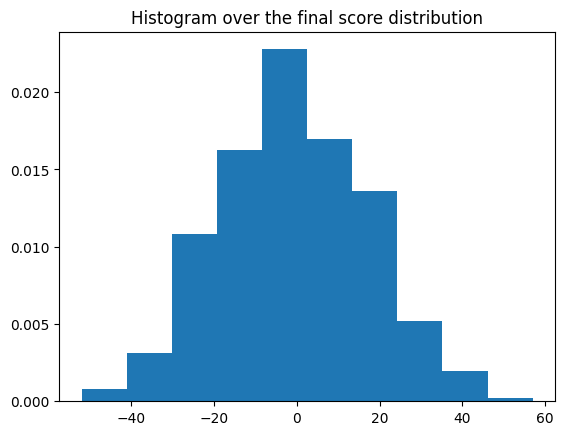

In [106]:
_eval = evaluate_boards(_board_history[-1])
plt.title("Histogram over the final score distribution")
plt.hist(_eval, density=True)
plt.show()

### Evaluate the winner of a game

The last function evaluates who won by calculating who signum function of the sum of the numpy array representing the baord.
The resulting number would be one if the game was wone by the player (white) or -1 if the enemy (black) won. The result would also 

In [92]:
def calculate_who_won(board_history: np.ndarray) -> np.ndarray:
    """Checks who won or is winning a game.

    Args:
        board_history: A stack of boards for evaluation. Shaped (70 * n * 8 * 8)

    Returns:
        The information who won for both player. 1 meaning the player won, -1 means the opponent lost. 0 represents a patt.
    """
    assert board_history.shape[-2:] == (8, 8)
    assert board_history.shape[0] == 70
    return np.sign(np.sum(board_history[-1], axis=(1, 2)))


np.random.seed(1)
np.testing.assert_array_equal(
    calculate_who_won(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]),
    np.array([-1, -1, -1, 1, -1, -1, -1, 1, -1, -1]),
)
np.random.seed(2)
np.testing.assert_array_equal(
    calculate_who_won(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0]),
    np.array([-1, -1, -1, -1, 1, -1, 1, -1, 1, 1]),
)


_boards = simulate_game(EXAMPLE_STACK_SIZE, (RandomPolicy(1), RandomPolicy(1)))[0]
%timeit calculate_who_won(_boards)

87.9 µs ± 5.91 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


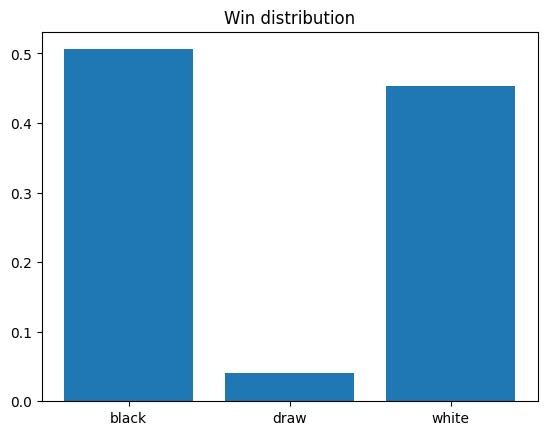

In [109]:
plt.title("Win distribution")
plt.bar(
    ["black", "draw", "white"],
    pd.Series(calculate_who_won(_board_history)).value_counts().sort_index() / _board_history.shape[1],
)
plt.show()

### Direct turn evaluation

Besides evaluating the turn there is always the possibility to calculate how much of an direct impact a single turn had.

In [93]:
def calculate_direct_score(board_history: np.ndarray) -> np.ndarray:
    """Calcualtes the delta score for all actions.
    
    Args:
        board_history: A history of board games or a stack of board games.  Shaped (70 * n * 8 * 8)
    """
    assert board_history.shape[0] == 70
    assert board_history.shape[-2:] == (8, 8)
    direct_score = np.sum(board_history, axis=(-2, -1))
    score = np.zeros_like(direct_score)
    score[:-1] = direct_score[1:] - direct_score[:-1]
    return score / 64


assert len(calculate_direct_score(_board_history).shape) == 2
assert calculate_direct_score(_board_history).shape[0] == SIMULATE_TURNS
np.random.seed(2)
np.testing.assert_equal(
    calculate_direct_score(simulate_game(10, (RandomPolicy(1), RandomPolicy(1)))[0])[
        :, 0
    ][:10]
    * 64,
    np.array(
        [3.0, -3.0, 3.0, -5.0, 5.0, -5.0, 3.0, -3.0, 7.0, -5.0],
    ),
)

When ploting the direct score it can be easily seen that the later turnse are point whise more importent. A bad opening however will not alow the player to keep those points. But it is easy to see that points not made at the begining of the game can be made at the end of the game. This allows for concentration on the gameplay and some preperation at the start of the game.

In [94]:
score_history = calculate_direct_score(_board_history)
score_history *= 64


@interact(turn=(0, 59))
def hist_direct_score(turn):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(
        f"Action space size analysis / total size estimate {np.prod(np.extract(mean_possibility_count, mean_possibility_count)):.4g}"
    )

    ax1.set_title(
        f"Histogram of scores changes on turn {turn} by {'white' if turn % 2 == 0 else 'black'}"
    )
    score = score_history[turn]
    bins = max(1, int(max(score) - min(score)) )
    ax1.hist(score, density=True, bins=bins)
    ax1.set_xlabel("Points made")
    ax1.set_ylabel("Score probability")
    ax2.set_title("Points scored at turn")
    ax2.set_xlabel("Turn")
    ax2.set_ylabel("Average points scored")
    ax2.errorbar(
        range(60),
        np.abs(np.mean(score_history, axis=1)[:60]),
        yerr=np.std(score_history, axis=1)[:60],
        label="Mean score at turn",
    )
    ax2.scatter(
        turn, np.abs(np.mean(score_history, axis=1))[:60][turn], marker="x", color="red"
    )
    ax2.legend()
    plt.show()

interactive(children=(IntSlider(value=29, description='turn', max=59), Output()), _dom_classes=('widget-intera…

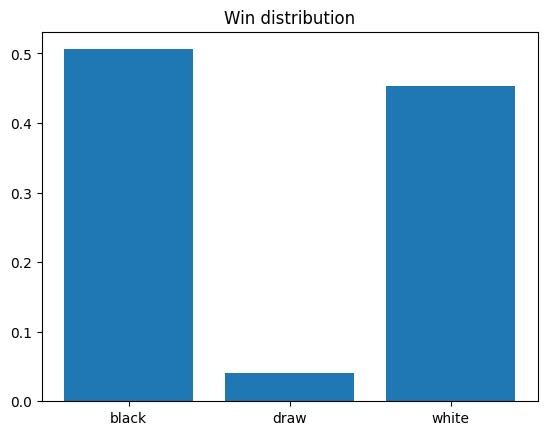

## Curating Q-Learing requirements
### Calculating discount tables

Since the a game stack is contains all steps even if no action is possible this needs to be corrected.
The normal formula for a reword is:

$E(s_{turn},a_{turn}) = \prod_{t=turn}^{70}\gamma_t$

Since turns that can't be taken do not have the element of uncertanty the discountation has to be excluded by setting the value to $1$ instead of $\gamma$.

$q_t =\begin{cases}1 & |a_t|=0\\\gamma & |a_t|>0\end{cases}$

$E(s_{turn},a_{turn}) = \prod_{t=turn}^{70}q_t$

The table below contains the aggregated discount factors for each reword fitting to the state history.

In [113]:
def get_gamma_table(board_history: np.ndarray, gamma_value: float) -> np.ndarray:
    """Calculates a discount table for a board history.
    
    Args:
        board_history: A history of game boards. Shaped (70 * n * 8 * 8)
        gamma_value: The default discount factor.
    """
    unchanged = history_changed(board_history)
    gamma_values = np.ones_like(unchanged, dtype=float)
    gamma_values[unchanged] = gamma_value
    return gamma_values


assert get_gamma_table(_board_history, 0.8).shape == _board_history.shape[:2]

### Calculating rewords



In [114]:
def calculate_q_reword(
    board_history: np.ndarray,
    who_won_fraction: float = 0.2,
    final_score_fraction: float=0.2,
    gamma: float=0.8,
) -> np.ndarray:
    """
    
    Args:
        board_history: 
        who_won_fraction: 
        final_score_fraction:
        gamma:
    """
    assert who_won_fraction + final_score_fraction <= 1
    assert final_score_fraction >= 0
    assert who_won_fraction >= 0

    gama_table = get_gamma_table(board_history, gamma)
    combined_score = np.zeros_like(gama_table)
    combined_score += calculate_direct_score(board_history) * (
        1 - (who_won_fraction + final_score_fraction)
    )
    combined_score[-1] += (
        calculate_final_evaluation_for_history(board_history)
        * final_score_fraction
        / 0.7
    )
    combined_score[-1] += calculate_who_won(board_history) * who_won_fraction
    for turn in range(SIMULATE_TURNS - 1, 0, -1):
        values = gama_table[turn] * combined_score[turn]
        combined_score[turn - 1] += values

    return combined_score


calculate_q_reword(
    _board_history, gamma=0.7, who_won_fraction=0, final_score_fraction=1
)

array([[-9.07181894e-11, -3.85552305e-10,  6.80386421e-11, ...,
         9.07181894e-11,  0.00000000e+00,  1.13397737e-10],
       [-1.29597413e-10, -5.50789007e-10,  9.71980601e-11, ...,
         1.29597413e-10,  0.00000000e+00,  1.61996767e-10],
       [-1.85139162e-10, -7.86841439e-10,  1.38854372e-10, ...,
         1.85139162e-10,  0.00000000e+00,  2.31423953e-10],
       ...,
       [-1.78571429e-01, -7.58928571e-01,  1.33928571e-01, ...,
         1.78571429e-01,  0.00000000e+00,  2.23214286e-01],
       [-1.78571429e-01, -7.58928571e-01,  1.33928571e-01, ...,
         1.78571429e-01,  0.00000000e+00,  2.23214286e-01],
       [-1.78571429e-01, -7.58928571e-01,  1.33928571e-01, ...,
         1.78571429e-01,  0.00000000e+00,  2.23214286e-01]])

In [ ]:
calculate_q_reword(
    _board_history, gamma=0.8, who_won_fraction=1, final_score_fraction=0
)[:, 0]

In [ ]:
calculate_q_reword(
    _board_history, gamma=0.8, who_won_fraction=0, final_score_fraction=0
)[:, 0] * 64

In [ ]:
def weights_init_normal(m):
    """Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.
    Source: https://stackoverflow.com/a/55546528/11003343
    """

    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find("Linear") != -1:
        y = m.in_features
        # m.weight.data should be taken from a normal distribution
        m.weight.data.normal_(0.0, 1 / np.sqrt(y))
        # m.bias.data should be 0
        m.bias.data.fill_(0)

In [ ]:
class DQLNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8 * 8 * 2, 128 * 2)
        self.fc2 = nn.Linear(128 * 2, 128 * 3)
        self.fc3 = nn.Linear(128 * 3, 128 * 2)
        self.fc4 = nn.Linear(128 * 2, 1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = functional.relu(x)
        x = self.fc2(x)
        x = functional.relu(x)
        x = self.fc3(x)
        x = functional.relu(x)
        x = self.fc4(x)
        x = torch.tanh(x)
        return x


class DQLSimple(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8 * 8 * 2, 64 * 3)
        self.fc2 = nn.Linear(64 * 3, 128 * 2)
        self.fc3 = nn.Linear(128 * 2, 1)

    def forward(self, x):
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x).float()
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = functional.relu(x)
        x = self.fc2(x)
        x = functional.relu(x)
        x = self.fc3(x)
        x = torch.tanh(x)
        return x


assert DQLNet().forward(np.zeros((5, 2, 8, 8))).shape == (5, 1)

In [ ]:
class SymmetryMode(Enum):
    MULTIPLY = "MULTIPLY"
    BREAK_SEQUENCE = "BREAK_SEQUENCE"

In [ ]:
_board_history, _action_history = simulate_game(100, (RandomPolicy(1), RandomPolicy(1)))
_board_history.shape, _action_history.shape

In [ ]:
def action_to_q_learning_format(
    board_history: np.ndarray, action_history: np.ndarray
) -> np.ndarray:
    q_learning_format = np.zeros(
        (SIMULATE_TURNS, board_history.shape[1], 2, 8, 8), dtype=float
    )
    q_learning_format[:, :, 0, :, :] = board_history
    q_learning_format[:, :, 1, :, :] = -1

    game_index = list(range(board_history.shape[1]))
    for turn_index in range(SIMULATE_TURNS):
        q_learning_format[
            turn_index,
            game_index,
            1,
            action_history[turn_index, game_index, 0],
            action_history[turn_index, game_index, 1],
        ] = 1
    return q_learning_format


%timeit action_to_q_learning_format(_board_history, _action_history)
%memit action_to_q_learning_format(_board_history, _action_history)


plot_othello_boards(
    action_to_q_learning_format(_board_history, _action_history)[:8, 0, 0]
)
plot_othello_boards(
    action_to_q_learning_format(_board_history, _action_history)[:8, 0, 1]
)

In [ ]:
def build_symetry_action(
    board_history: np.ndarray, action_history: np.ndarray
) -> np.ndarray:
    board_history = board_history.copy()
    board_history[1::2] *= -1
    q_learning_format = np.zeros(
        (2, 2, 2, SIMULATE_TURNS, board_history.shape[1], 2, 8, 8)
    )
    q_learning_format[0, 0, 0, :, :, :, :, :] = action_to_q_learning_format(
        board_history, action_history
    )
    q_learning_format[1, 0, 0, :, :, :, :, :] = np.transpose(
        q_learning_format[0, 0, 0, :, :, :, :, :], [0, 1, 2, 4, 3]
    )
    q_learning_format[:, 1, 0, :, :, :, :, :] = q_learning_format[
        :, 0, 0, :, :, :, ::-1, :
    ]
    q_learning_format[:, :, 1, :, :, :, :, :] = q_learning_format[
        :, :, 0, :, :, :, :, ::-1
    ]
    return q_learning_format


%timeit build_symetry_action(_board_history, _action_history)
%memit build_symetry_action(_board_history, _action_history)
build_symetry_action(_board_history, _action_history).shape

In [ ]:
def live_history(training_history: pd.DataFrame, ai_name: str | None):
    clear_output(wait=True)
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(14, 7))
    _ = training_history[
        [c for c in training_history.columns if c[1] == "final_score"]
    ].plot(ax=ax1)
    plt.title("Final score")
    plt.xlabel("epochs")
    _ = training_history[[c for c in training_history.columns if "win" in c[1]]].plot(
        ax=ax2
    )
    plt.title("Win score")
    plt.xlabel("epochs")
    _ = np.sqrt(
        training_history[[c for c in training_history.columns if "loss" == c[0]]]
    ).plot(ax=ax3)
    ax3.set_yscale("log")
    plt.xlabel("epochs")
    if max_epochs:
        plt.xlim(0, max_epochs)

    plt.title("Loss")
    fig.subtitle(f"Training history of {ai_name}" if ai_name else f"Training history")
    plt.show()

In [ ]:
class QLPolicy(GamePolicy):
    # noinspection PyProtectedMember
    def __init__(
        self,
        epsilon: float,
        neural_network: DQLNet | DQLSimple,
        symmetry_mode: SymmetryMode,
        gamma: float = 0.8,
        who_won_fraction: float = 0,
        final_score_fraction: float = 0,
        optimizer: torch.optim.Optimizer | None = None,
        loss: nn.modules.loss._Loss | None = None,
    ):
        super().__init__(epsilon)
        assert 0 <= gamma <= 1
        self.gamma: float = gamma
        del gamma
        self.symmetry_mode: SymmetryMode = symmetry_mode
        del symmetry_mode
        self.neural_network: DQLNet | DQLSimple = neural_network
        del neural_network
        self.who_won_fraction: float = who_won_fraction
        del who_won_fraction
        self.final_score_fraction: float = final_score_fraction
        del final_score_fraction

        if optimizer is None:
            self.optimizer = torch.optim.Adam(self.neural_network.parameters(), lr=5e-5)
        else:
            self.optimizer = optimizer
        if loss is None:
            self.loss = nn.MSELoss()
        else:
            self.loss = loss
        self.training_results: list[dict[tuple[str, str], float]] = []
        self.loss_history: list[float] = []

    @property
    def policy_name(self) -> str:
        symmetry_name = {SymmetryMode.MULTIPLY: "M", SymmetryMode.BREAK_SEQUENCE: "B"}
        g = f"{self.gamma:.1f}".replace(".", "")
        ww = f"{self.who_won_fraction:.1f}".replace(".", "")
        fsf = f"{self.final_score_fraction:.1f}".replace(".", "")
        return f"QL-{symmetry_name[self.symmetry_mode]}-G{g}-WW{ww}-FSF{fsf}-{self.neural_network.__class__.__name__}-{self.loss.__class__.__name__}"

    def __repr__(self) -> str:
        return self.policy_name

    def __str__(self) -> str:
        return self.policy_name

    def _internal_policy(self, boards: np.ndarray) -> np.ndarray:
        results = np.zeros_like(boards, dtype=float)
        results = torch.from_numpy(results).float()
        q_learning_boards = np.zeros((boards.shape[0], 2, 8, 8))
        q_learning_boards[:, 0, :, :] = boards
        poss_turns = boards == 0  # checks where fields are empty.
        poss_turns &= binary_dilation(boards == -1, SURROUNDING)
        turn_possible = np.any(poss_turns, axis=0)
        for action_x, action_y in itertools.product(range(8), range(8)):
            if not turn_possible[action_x, action_y]:
                continue
            _q_learning_board = q_learning_boards[
                poss_turns[range(boards.shape[0]), action_x, action_y]
            ].copy()
            _q_learning_board[
                range(_q_learning_board.shape[0]), 1, action_x, action_y
            ] = 1

            ql_result = self.neural_network.forward(_q_learning_board)
            results[poss_turns[:, action_x, action_y], action_x, action_y] = (
                ql_result.reshape(-1) + 0.1
            )
        return results.cpu().detach().numpy()

    def generate_trainings_data(
        self, generate_data_size: int
    ) -> tuple[torch.Tensor, torch.Tensor]:
        train_boards, train_actions = simulate_game(generate_data_size, (self, self))
        action_possible = ~np.all(train_actions[:, :] == -1, axis=2)
        q_leaning_formatted_action = build_symetry_action(train_boards, train_actions)
        q_rewords = calculate_q_reword(
            board_history=train_boards,
            who_won_fraction=self.who_won_fraction,
            final_score_fraction=self.final_score_fraction,
        )
        q_rewords[1::2, :] *= -1
        if self.symmetry_mode == SymmetryMode.MULTIPLY:
            new_q_rewords = np.zeros((2, 2, 2) + q_rewords.shape)
            for i, k, j in itertools.product((0, 1), (0, 1), (0, 1)):
                new_q_rewords[i, k, j] = q_rewords
            q_rewords = new_q_rewords
            action_possible = np.array([action_possible] * 8).reshape(-1)

        elif self.symmetry_mode == SymmetryMode.BREAK_SEQUENCE:
            axis1 = np.random.randint(0, high=2, size=SIMULATE_TURNS, dtype=int)
            axis2 = np.random.randint(0, high=2, size=SIMULATE_TURNS, dtype=int)
            axis3 = np.random.randint(0, high=2, size=SIMULATE_TURNS, dtype=int)
            q_leaning_formatted_action = q_leaning_formatted_action[
                axis1, axis2, axis3, range(SIMULATE_TURNS)
            ]
            action_possible = action_possible.reshape(-1)

        return (
            torch.from_numpy(
                q_leaning_formatted_action.reshape(-1, 2, BOARD_SIZE, BOARD_SIZE)[
                    action_possible
                ]
            ).float(),
            torch.from_numpy(q_rewords.reshape(-1, 1)[action_possible]).float(),
        )

    def train_batch(self, nr_of_games: int) -> None:
        x_train, y_train = self.generate_trainings_data(nr_of_games)
        y_pred = self.neural_network.forward(x_train)
        loss_score = self.loss(y_pred, y_train)
        self.optimizer.zero_grad()
        self.loss_history.append(loss_score.item())
        loss_score.backward()
        # Update the parameters
        self.optimizer.step()
        # generate trainings data

    def evaluate_model(self, compare_models: list[GamePolicy], nr_of_games: int):
        result_dict: dict[tuple[str, str], float] = {}
        eval_copy = copy.copy(self)
        eval_copy._epsilon = 1
        for model in compare_models:
            boards_black, _ = simulate_game(nr_of_games, (eval_copy, model))
            boards_white, _ = simulate_game(nr_of_games, (model, eval_copy))
            win_eval_white = calculate_who_won(boards_white)
            win_eval_black = calculate_who_won(boards_black)
            result_dict[(model.policy_name, "final_score")] = (
                float(
                    np.mean(
                        calculate_final_evaluation_for_history(boards_black)
                        + (calculate_final_evaluation_for_history(boards_white) * -1)
                    )
                )
                * 64
            )
            result_dict[(model.policy_name, "white_win")] = (
                np.sum(win_eval_white == -1) / nr_of_games
            )
            result_dict[(model.policy_name, "white_lose")] = (
                np.sum(win_eval_white == 1) / nr_of_games
            )
            result_dict[(model.policy_name, "black_win")] = (
                np.sum(win_eval_black == 1) / nr_of_games
            )
            result_dict[(model.policy_name, "black_lose")] = (
                np.sum(win_eval_black == -1) / nr_of_games
            )

        result_dict[("loss", "mean")] = float(np.mean(np.array(self.loss_history)))
        result_dict[("loss", "min")] = np.min(np.array(self.loss_history))
        result_dict[("loss", "max")] = np.max(np.array(self.loss_history))
        self.loss_history = []
        result_dict[("base", "base")] = nr_of_games
        return result_dict

    def save(self):
        filename: str = f"{self.policy_name}-{len(self.training_results)}"
        with open(TRAINING_RESULT_PATH / Path(f"{filename}.pickle"), "wb") as f:
            pickle.dump(self.training_results, f)
        torch.save(
            self.neural_network.state_dict(),
            TRAINING_RESULT_PATH / Path(f"{filename}.torch"),
        )

    def load(self):
        pickle_files = glob.glob(f"{TRAINING_RESULT_PATH}/{self.policy_name}-*.pickle")
        torch_files = glob.glob(f"{TRAINING_RESULT_PATH}/{self.policy_name}-*.torch")

        assert len(pickle_files) == len(torch_files)
        if not pickle_files:
            return

        pickle_dict = {
            int(file.split("-")[-1].split(".")[0]): file for file in pickle_files
        }
        torch_dict = {
            int(file.split("-")[-1].split(".")[0]): file for file in torch_files
        }
        pickle_file = pickle_dict[max(pickle_dict.keys())]
        torch_file = torch_dict[max(torch_dict.keys())]

        with open(pickle_file, "rb") as f:
            self.training_results = pickle.load(f)

        self.neural_network.load_state_dict(torch.load(Path(torch_file)))

    def train(
        self,
        epochs: int,
        batches: int,
        batch_size: int,
        eval_batch_size: int,
        compare_with: list[GamePolicy],
        save_every_epoch: bool = True,
        live_plot: bool = True,
    ) -> pd.DataFrame:
        assert epochs > 0
        epoch_progress = tqdm(range(epochs), unit="epoch")
        for _ in epoch_progress:
            for _ in tqdm(range(batches), unit="batch"):
                self.train_batch(batch_size)
            self.training_results.append(
                self.evaluate_model(compare_with, eval_batch_size)
            )
            if save_every_epoch:
                self.save()
            if live_plot:
                self.plot_history()
            display(epoch_progress.container)
        return self.history

    def plot_history(self) -> None:
        if not self.training_results:
            return None
        return live_history(self.history, None)

    @property
    def history(self) -> pd.DataFrame:
        if not self.training_results:
            return pd.DataFrame()
        pandas_result = pd.DataFrame(self.training_results)
        pandas_result.columns = pd.MultiIndex.from_tuples(pandas_result.columns)
        return pandas_result


ql_policy1 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.8,
    who_won_fraction=1,
    final_score_fraction=0,
)

assert copy.copy(ql_policy1) is not ql_policy1
assert copy.copy(ql_policy1).neural_network is ql_policy1.neural_network

# noinspection PyProtectedMember
t1, t2 = ql_policy1._internal_policy(get_new_games(2))

## Symmetry debug

In [ ]:
_train_boards, _train_actions = simulate_game(10, (RandomPolicy(0), RandomPolicy(0)))
_action_possible = ~np.all(_train_actions[:, :] == -1, axis=2)
_q_leaning_formatted_action = action_to_q_learning_format(_train_boards, _train_actions)
_train_boards.shape

In [ ]:
ql_policy1 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy1.policy_name

In [ ]:
ql_policy1 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy1.policy_name

In [ ]:
ql_policy2 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.8,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy2.policy_name

In [ ]:
ql_policy3 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=1,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy3.policy_name

In [ ]:
ql_policy4 = QLPolicy(
    0.92,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=1,
    final_score_fraction=0,
)
ql_policy4.policy_name

In [ ]:
ql_policy5 = QLPolicy(
    0.95,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0.3,
    final_score_fraction=0.3,
)
ql_policy5.policy_name

In [ ]:
ql_policy6 = QLPolicy(
    0.95,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.3,
    final_score_fraction=0.65,
)
ql_policy6.policy_name

In [ ]:
ql_policy7 = QLPolicy(
    0.95,
    neural_network=DQLSimple(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.2,
    final_score_fraction=0.65,
)
ql_policy6.policy_name

In [ ]:
ql_policy8 = QLPolicy(
    0.92,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.8,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy2.policy_name

In [ ]:
ql_policy9 = QLPolicy(
    0.92,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=1,
    who_won_fraction=0,
    final_score_fraction=1,
)
ql_policy3.policy_name

In [ ]:
ql_policy10 = QLPolicy(
    0.92,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=1,
    final_score_fraction=0,
)
ql_policy4.policy_name

In [ ]:
ql_policy11 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.9,
    who_won_fraction=0.3,
    final_score_fraction=0.3,
)
ql_policy5.policy_name

In [ ]:
ql_policy12 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.3,
    final_score_fraction=0.65,
)
ql_policy6.policy_name

In [ ]:
ql_policy13 = QLPolicy(
    0.95,
    neural_network=DQLNet(),
    symmetry_mode=SymmetryMode.MULTIPLY,
    gamma=0.92,
    who_won_fraction=0.2,
    final_score_fraction=0.65,
)
ql_policy6.policy_name

In [ ]:
ql_policy = ql_policy1
ql_policy.load()
ql_policy.train(15, 10, 1000, 250, [RandomPolicy(0), GreedyPolicy(0)])

In [ ]:
for i in range(100):
    for ql_policy in [ql_policy8, ql_policy9, ql_policy10, ql_policy11, ql_policy12, ql_policy13]:
        ql_policy.load()
        ql_policy.train(1, 10, 1000, 250, [RandomPolicy(0), GreedyPolicy(0)])

In [ ]:
ql_policy.load()

In [ ]:
ql_policy.plot_history()

In [ ]:
ql_policy.train(100, 10, 1000, 250, [RandomPolicy(0), GreedyPolicy(0)])

In [ ]:
_boards_greedy_l, _action_greedy_l = simulate_game(
    500, (RandomPolicy(0), GreedyPolicy(0)), tqdm_on=True
)
_boards_greedy_r, _action_greedy_r = simulate_game(
    500, (GreedyPolicy(0), RandomPolicy(0)), tqdm_on=True
)

In [ ]:
_boards_greedy_r.shape

In [ ]:
np.sum(_boards_greedy_l[-1]) / 500, -np.sum(_boards_greedy_r[-1]) / 500

In [ ]:
ql_policy._epsilon = 1
_boards_l, _actions_l = simulate_game(500, (RandomPolicy(0), ql_policy), tqdm_on=True)
_boards_r, _actions_r = simulate_game(500, (ql_policy, RandomPolicy(0)), tqdm_on=True)

In [ ]:
_boards_l.shape

In [ ]:
np.sum(_boards_l[-1]) / 500, -np.sum(_boards_r[-1]) / 500

In [ ]:
_boards_policy_l, _ = simulate_game(500, (ql_policy, GreedyPolicy(0)), tqdm_on=True)
_boards_policy_r, _ = simulate_game(500, (GreedyPolicy(0), ql_policy), tqdm_on=True)

In [ ]:
np.sum(_boards_policy_l[-1]) / 500, np.sum(_boards_policy_r[-1]) / 500

In [ ]:
calculate_final_evaluation_for_history(
    _boards_policy_l
).mean() * 64, calculate_final_evaluation_for_history(_boards_policy_r).mean() * 64

In [ ]:
@interact(game_start="0")
def plot_training(game_start: int) -> None:
    boards_at_once = 12
    if not game_start:
        return
    game_start = int(game_start)
    start = game_start * boards_at_once
    end = start + boards_at_once
    boards_selected = _boards_l[start:end, 0]
    scores_selected = _boards_r[start:end, 0]

    # noinspection PyProtectedMember
    p_scores = np.max(
        ql_policy._internal_policy(_boards[start:end, 0].cpu().detach().numpy()),
        axis=(1, 2),
    ).tolist()

    scores2 = np.array(
        [
            f"Q:{float(score[0]):2e}@P:{float(score[1]):2e}"
            for score in zip(scores_selected, p_scores)
        ]
    )
    plot_othello_boards(
        boards_selected,
        scores=scores2,
    )

In [ ]:
ql_policy.history

In [ ]:
policy_list = [
    RandomPolicy(0),
    GreedyPolicy(0),
    ql_policy1,
    ql_policy2,
    ql_policy3,
    ql_policy4,
    ql_policy5,
]

RESULTS_FILE: Final[str] = "results.pickle"
if not os.path.exists(RESULTS_FILE):
    policy_list = [RandomPolicy(0), GreedyPolicy(0), ql_policy]
    result_df = pd.DataFrame(
        index=[policy.policy_name for policy in policy_list],
        columns=[policy.policy_name for policy in policy_list],
    )
else:
    result_df = pd.read_pickle(RESULTS_FILE)
nr_of_eval_games = 2000
for policy1, policy2 in tqdm(list(itertools.product(policy_list, policy_list))):
    if not pd.isna(result_df.at[policy1.policy_name, policy2.policy_name]):
        continue
    _result_dict = {}
    _boards_black, _ = simulate_game(nr_of_eval_games, (policy1, policy2))
    _win_eval_black = calculate_who_won(_boards_black)
    _result_dict["final_score"] = float(
        np.mean(calculate_final_evaluation_for_history(_boards_black))
    )
    _result_dict["win"] = np.sum(_win_eval_black == 1) / nr_of_eval_games
    _result_dict["lose"] = np.sum(_win_eval_black == -1) / nr_of_eval_games
    result_df.at[policy1.policy_name, policy2.policy_name] = _result_dict
    result_df.to_pickle(RESULTS_FILE)

In [ ]:
result_df.applymap(lambda x: x["win"])

In [ ]:
result_df.applymap(lambda x: x["final_score"])

In [ ]:
raise NotImplementedError

In [ ]:
boards_and_actions, _score = ql_policy.generate_trainings_data(1)
print(boards_and_actions.shape)
print(_score.shape)

In [ ]:
boards_and_actions.shape

In [ ]:
plot_othello_boards(boards_and_actions[:8, 0])

In [ ]:
_score[:8, 0]

In [ ]:
plot_othello_boards(boards1[:60, 0])

## Train a model

# Sources

* Game rules and example board images [https://en.wikipedia.org/wiki/Reversi](https://en.wikipedia.org/wiki/Reversi)
* Game rules and example game images [https://de.wikipedia.org/wiki/Othello_(Spiel)](https://de.wikipedia.org/wiki/Othello_(Spiel))
* Game strategy examples [https://de.wikipedia.org/wiki/Computer-Othello](https://de.wikipedia.org/wiki/Computer-Othello)
* Image for 8 directions [https://www.researchgate.net/journal/EURASIP-Journal-on-Image-and-Video-Processing-1687-5281](https://www.researchgate.net/journal/EURASIP-Journal-on-Image-and-Video-Processing-1687-5281)

In [ ]:
import sys


def sizeof_fmt(num, suffix="B"):
    """by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified"""
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, "Yi", suffix)


for name, size in sorted(
    ((name, sys.getsizeof(value)) for name, value in list(locals().items())),
    key=lambda x: -x[1],
)[:20]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

## Write story about mixed oreder!


